## Auction Sale Price

Based on fastai course https://github.com/fastai

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

In [2]:
data = pd.read_csv("./data/Train.csv", low_memory = False, parse_dates = ["saledate"])

data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.SalePrice = np.log(data.SalePrice)

In [4]:
def split_date(data_frame, col_name):
    ''' helper function to split the date into corresponding categoricals '''
    
    # split date into corresponding columns
    split_date.props = ["year", "month", "day"]
    
    # extract date column
    col_date = data_frame[col_name]
    
    # extracting date properties and storing into individual columns
    for d in split_date.props:
        if(hasattr(col_date.dt, d)):
            data_frame[f"sale_{d}"] = getattr(col_date.dt, d)
            
    # extracting timestamp
    data_frame["sale_timestamp"] = col_date.astype(np.int64) // (10 ** 9)
    
    # removing the raw column
    data_frame.drop(columns = [col_name], inplace = True)
    
    
def trans_categorical(data_frame):
    ''' helper function to tranform text-based columns to numerical(categorical ones)'''
    
    # loop through each col
    for label, column in data_frame.items():
        
        # if string convert as category
        if(is_string_dtype(data_frame[label])):
            data_frame[label] = data_frame[label].astype("category")
            
            
def trans_numerical(data_frame, target):
    ''' helper function for retrieving numerical features and targets, 
    null values are transformed into the median value of the column. '''

    # copy the data frame
    data_frame_c = data_frame.copy()

    # loop through each col and normalize
    for label, column in data_frame_c.items():
        
        # check if numerical and contain nulls
        if(is_numeric_dtype(column) and pd.isnull(column).sum() != 0):
            
            # column median
            median = column.median()
            
            # fill the data with the median
            data_frame_c[label] = column.fillna(median)
            
    # loop through each col and change to numerical
    for label, column in data_frame_c.items(): 
        
        # if numerical nothing to do
        if(not is_numeric_dtype(column)):
            
            # change to numerical data
            data_frame_c[label] = data_frame_c[label].astype("category").cat.codes + 1
    
    return [ data_frame_c.drop(columns = [ target ]), data_frame_c[target].values ]

In [5]:
split_date(data, "saledate")

trans_categorical(data)

In [6]:
is_categorical_dtype(data["ProductSize"])

data.ProductSize.cat.categories

Index(['Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small'], dtype='object')

In [7]:
data.ProductSize.cat.codes.head()

0   -1
1    3
2   -1
3    5
4   -1
dtype: int8

In [8]:
data.isnull().sum().head()

SalesID       0
SalePrice     0
MachineID     0
ModelID       0
datasource    0
dtype: int64

In [9]:
features, targets = trans_numerical(data, "SalePrice")

In [231]:
def pred_model(train, valid, n_estimators = 10, min_samples_leaf = 1, max_features = 'auto', oob_score = False):
    ''' helper function to train and validate a model, train and valid are tuples of features and targets '''
    
    # create a random forest
    model = RandomForestRegressor(n_estimators = n_estimators, min_samples_leaf = min_samples_leaf,\
                                  max_features = max_features, oob_score = oob_score)
    
    # fit the training features and targets
    model.fit(train[0], train[1])
    
    return (model, model.score(valid[0], valid[1]))

In [11]:
train = (features, targets)

In [12]:
model, score = pred_model(train, train)

print(f"Model is heavily overfitting with {score} and won't do well on new data samples")

Model is heavily overfitting with 0.9830797914787865 and won't do well on new data samples


In [13]:
def split_dataset(data, threshold, columns = None):
    ''' helper function to split data into training and validation set '''
    
    # provisional data copied
    data_prov = data.copy()
    
    # filter columns
    if(columns is not None):
        data_prov = data_prov[columns]

    return data_prov[threshold:], data_prov[:threshold].copy()

def split_data(features, targets, threshold, columns = None):
    ''' helper function to split data into training and validation set '''
    
    # splitting features
    train_features, valid_features = split_dataset(features, threshold, columns = columns)
    
    # splitting targets
    train_targets, valid_targets = split_dataset(targets, threshold, columns = None)
    
    return (train_features, train_targets), (valid_features, valid_targets)

In [14]:
train, valid = split_data(features, targets, threshold = 12000)

In [15]:
model, score = pred_model(train, valid)

print(f"Model is heavily overfitting on train set as it does {score} on unseen before samples")

Model is heavily overfitting on train set as it does 0.8783762813641063 on unseen before samples


In [16]:
model, score = pred_model(train, valid, n_estimators = 40, min_samples_leaf = 6, max_features = 0.6)

print(f"Generalizes better with {score} by early stopping, using smaller pool(features) and random subsets for training")

Generalizes better with 0.9005931040943463 by early stopping, using smaller pool(features) and random subsets for training


In [18]:
print(model.predict(valid[0][:1])[0])

10.975197960798123


In [20]:
# stacking each tree prediction with TxP => PxT
tree_scores = np.stack([ t.predict(valid[0]) for t in model.estimators_ ]).transpose()

# pool a smaller subset of results from a single prediction
tree_scores_sub = [ str(round(t, 2)) for t in tree_scores[0][:8] ]

score_mean = round(np.mean(tree_scores[0]), 5)
score_std = round(np.std(tree_scores[0]), 5)

print(", ".join(tree_scores_sub) + "...")
print(f"Trees that sees a different subset of data with higher information gain when splitting will complement\
 those that don't so well - {score_mean}, with {score_std} confidence")

11.1, 11.22, 10.84, 11.11, 10.8, 11.18, 11.36, 11.12...
Trees that sees a different subset of data with higher information gain when splitting will complement those that don't so well - 10.9752, with 0.29763 confidence


In [21]:
data_rt, data_rv  = split_dataset(data, 12000)

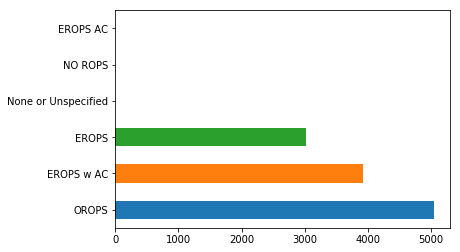

In [24]:
x = data_rv.copy()

x['Pred'] = np.mean(tree_scores, axis = 1)
x['PredDeviation'] = np.std(tree_scores, axis = 1)

x.Enclosure.value_counts().plot.barh()

In [25]:
columns = ["Enclosure", "SalePrice", "Pred", "PredDeviation"]

p = x[columns].groupby("Enclosure", as_index = False).mean()

p

,Enclosure,SalePrice,Pred,PredDeviation
0,EROPS,9.964365,9.972402,0.223130
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.726390,10.692962,0.216322
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.899330,9.916311,0.176180


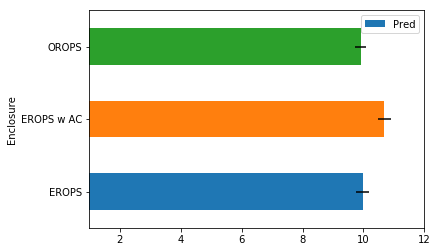

In [26]:
p[~pd.isnull(p.SalePrice)].plot("Enclosure", "Pred", "barh", xerr = "PredDeviation", xlim = (1, 12))

### Feature importance

In [27]:
def extract_feature_importances(model, data, trim = -1, threshold = None):
    ''' helper function to extract feature importances '''
    
    # create a feature importances data frame
    feature_importances = pd.DataFrame({"columns" : data.columns, "importance" : model.feature_importances_})

    # descending ordering and trim
    feature_importances = feature_importances.sort_values("importance", ascending = False)[:trim]
    
    # apply filtering on unnecessary features
    if(threshold is not None):
        feature_importances = feature_importances[feature_importances.importance > threshold]
    
    return feature_importances

In [28]:
# extracting feature importances
feature_importances = extract_feature_importances(model, train[0], threshold = 0.003)

feature_importances.head(n = 10)

,columns,importance
5,YearMade,0.176743
37,Coupler_System,0.122650
14,fiProductClassDesc,0.099769
13,ProductSize,0.090443
2,ModelID,0.061960
54,sale_timestamp,0.057642
38,Grouser_Tracks,0.053275
10,fiSecondaryDesc,0.040375
39,Hydraulics_Flow,0.037247
19,Enclosure,0.035988


In [32]:
# extracting train and validation set with filtered columns based on importance 
train_f, valid_f = split_data(features, targets, threshold = 12000, columns = feature_importances["columns"])

# re-run model training
model_f, score_f = pred_model(train_f, valid_f, n_estimators = 40, min_samples_leaf = 6, max_features = 0.6)

print(f"Less redunant data result in less chance to get snagged into a split that would become less\
 significant as more splits will follow up - {round(score_f, 6)}")

Less redunant data result in less chance to get snagged into a split that would become less significant as more splits will follow up - 0.898306


### Removing redundant features

In [308]:
def generate_feature_dependencies(features, columns = None):
    ''' helper function to extract feature dependencies by clustering '''

    # make copy
    features_filtered = features.copy()
    
    # filter columns
    if(columns is not None):
        features_filtered = features_filtered[columns]

    # calculate correlations between different columns
    correlation = spearmanr(features_filtered).correlation

    # compute clusters based on average distance
    clusters = hierarchy.linkage(correlation, method = 'average')

    # explicitly set bigger size
    fig = plt.figure(figsize = (28, 14))
    
    # generate a dendrogram
    hierarchy.dendrogram(clusters, labels = features_f.columns, orientation = 'right', leaf_font_size = 18)

    # show plot
    plt.show()
    
    return (clusters, features_filtered)

def validate_dependency(columns):
    
    def validator(column_index):

        # new columns filtered
        columns_filtered = columns[:column_index] + columns[column_index + 1:]

        # extracting train and validation set with filtered columns based on importance 
        train, valid = split_data(features, targets, threshold = 12000, columns = columns_filtered)

        # re-run model training
        model, score = pred_model(train, valid, n_estimators = 25, min_samples_leaf = 4,\
                                  max_features = 0.5, oob_score = True)

        return model.oob_score_
    
    return validator

def extract_relevant_dependencies(features, clusters, threshold):
    ''' helper function to remove feature dependencies by a threshold '''

    # make copy
    features_filtered = features.copy()

    # extracting unnecessary clusters
    clusters_filtered = clusters[clusters[:, 2] < threshold][:, :2].astype(dtype = "int32")
    
    # our validator
    v = validate_dependency(features_filtered.columns.values.tolist())
    
    # extracting unnecessary dependencies(columns), only a singleton not both
    columns_filtered = [ x[0] if v(x[0]) > v(x[1]) else x[1] for x in clusters_filtered ]

    # discarding columns
    features_filtered.drop(features_filtered.columns[list(columns_filtered)], inplace = True, axis = 1)
    
    return columns_filtered

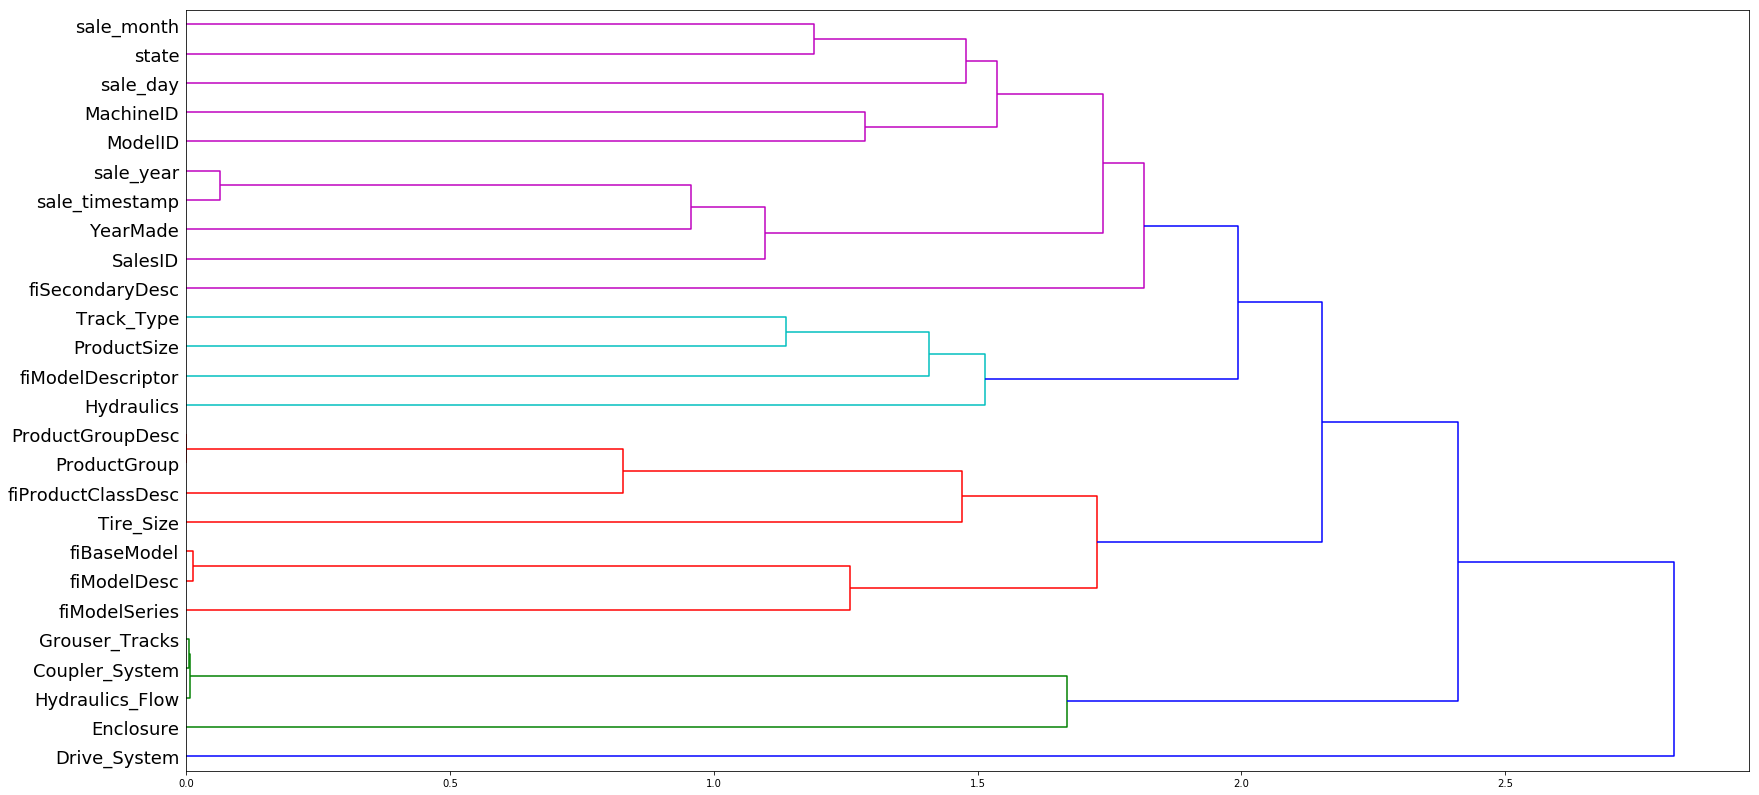

In [183]:
clusters, features_filtered = generate_feature_dependencies(features, columns = feature_importances["columns"])

In [ ]:
columns_relevant = extract_relevant_dependencies(features_filtered, clusters, 0.02)

In [316]:
print("Relevant columns extracted from binary dependency: " +\
      ", ".join(features_filtered.columns[columns_relevant].tolist()))

Relevant columns extracted from binary dependency: ProductGroupDesc, Grouser_Tracks, Hydraulics_Flow, fiModelDesc


In [230]:
# extracting train and validation set with filtered columns based on importance 
train_ff, valid_ff = split_data(features, targets, threshold = 12000, columns = columns_relevant)

# re-run model training
model_ff, score_ff = pred_model(train_ff, valid_ff, n_estimators = 40,\
                                min_samples_leaf = 6, max_features = 0.6, oob_score = True)

print(f"Discarding unnecesary dependencies and re-running model training - {round(score_ff, 6)}")

Out-of-bag score - 0.9074289577301153
Discarding unnecesary dependencies and re-running model training - 0.895674
